# Part 2: Parameter estimation (optimization) on synthetic data

In this notebook, we demonstrate how one can use Collimator models for optimization. For a pulse discharge test (discharge current applied as a pulse as in previous tutorial), we will first generate synthetic $v_t$ data from the Collimator model. Here we will known a set of known parameters, i.e. known curves representing the dependencies of $v_0$, $R_s$, $R_1$, and $C_1$ on the soc $s$. Then we will add some noise to the terminal voltage output, and imagine that this is the experimental $v_t$ curve that one obtains in a pulse discharge test. The goal then, would be to estimate the the $v_0(s)$, $R_s(s)$, $R_1(s)$, and $C_1(s)$ through optimisation, i.e. minimising the discrepancy between what the model outputs, as parameters are varied through the optimizer, and the synthetic experimental curve.

## Generating synthetic data
We have put the Battery class (Method-1) showcased in the previous tutorial into `collimator/examples/battery_ecm.py`, so that we can import it here. Next, we use the same simulation technique as shown previously to generate a $v_t$ output, but with some *a priori* chosen $v_0(s)$, $R_s(s)$, $R_1(s)$, and $C_1(s)$ curves.

In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp

import collimator
from collimator.library import Pulse
from collimator.framework import LeafSystem

from collimator.simulation import SimulatorOptions

from collimator.models import Battery


from collimator import logging

logging.set_log_level(logging.ERROR)

%matplotlib inline
import matplotlib.pyplot as plt

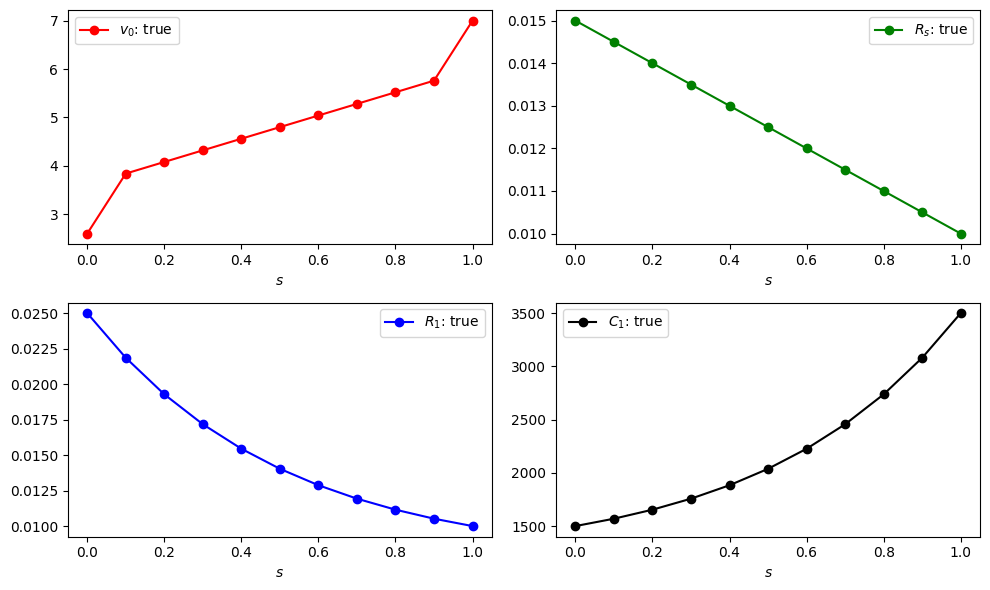

In [2]:
# Generate synthetic v0, Rs, R1, Rs curves representing dependency on soc.
# we label them as `true` as they will be the ground truth that the
# estimation/optimisation procedure will seek to find.

soc_points_true = jnp.linspace(0.0, 1.0, 11)
v0_points_true = 3.6 + (5.0 - 2.6) * soc_points_true
v0_points_true = v0_points_true.at[0].set(v0_points_true[0] - 1.0)
v0_points_true = v0_points_true.at[-1].set(v0_points_true[-1] + 1.0)

Rs_points_true = 15e-03 + (10e-03 - 15e-03) * soc_points_true
lamb = 2.0
R1_points_true = 10e-03 + (25e-03 - 10e-03) * (
    jnp.exp(-lamb * soc_points_true) - jnp.exp(-lamb)
) / (1 - jnp.exp(-lamb))
C1_points_true = 1.5e03 + (3.5e03 - 1.5e03) * (jnp.exp(lamb * soc_points_true) - 1) / (
    jnp.exp(lamb) - 1
)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(soc_points_true, v0_points_true, "-ro", label=f"$v_0$: true")
axs[0, 1].plot(soc_points_true, Rs_points_true, "-go", label=f"$R_s$: true")
axs[1, 0].plot(soc_points_true, R1_points_true, "-bo", label=f"$R_1$: true")
axs[1, 1].plot(soc_points_true, C1_points_true, "-ko", label=f"$C_1$: true")
for ax in axs.flatten():
    ax.set_xlabel(r"$s$")
    ax.legend(loc="best")
plt.tight_layout()
plt.show()

With the above being the true battery parameters, let's simulate the system and obtain the $v_t$ output

Initialized callback battery:u_0 with prereqs []
Initialized callback battery:battery_ode with prereqs [1, 2, 8]
Initialized callback battery:y_0 with prereqs [8]
Initialized callback battery:y_1 with prereqs [8]
Initialized callback discharge_current:out_0 with prereqs [1]


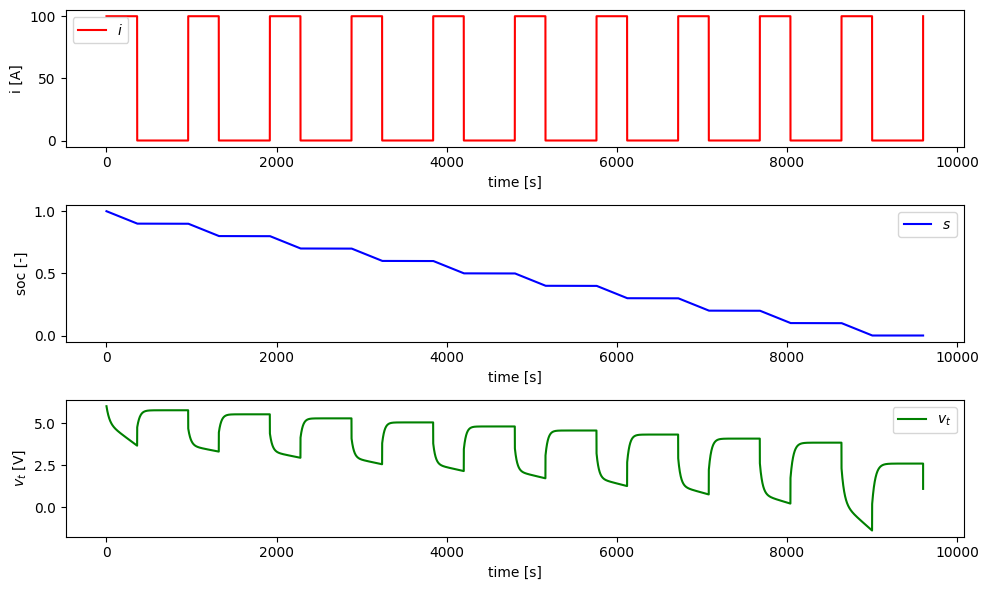

In [3]:
builder = collimator.DiagramBuilder()

# Create a battery with the above generated parameters
battery = builder.add(
    Battery(
        soc_0=1.0,  # test states with fully charge battery
        vc1_0=0.0,  # zero capacitor voltage as battery was disconnected for a long time
        Q=100.0,  # Total capacity of the battery (known)
        soc_points=soc_points_true,
        v0_points=v0_points_true,
        Rs_points=Rs_points_true,
        R1_points=R1_points_true,
        C1_points=C1_points_true,
        name="battery",
    )
)

# Pulse block to represent pulse discharge test
discharge_current = builder.add(
    Pulse(100.0, 6 / 16.0, 16 * 60.0, name="discharge_current")
)

# We have two blocks/LeafSystems: discharge_current and battery. We need to connect the output
# of the discharge_current to the input of the battery.
builder.connect(discharge_current.output_ports[0], battery.input_ports[0])

diagram = builder.build()
context = diagram.create_context()  # Create default context

# Specify which signals to record in the simulation output
recorded_signals = {
    "discharge_current": discharge_current.output_ports[0],
    "soc": battery.output_ports[0],
    "vt": battery.output_ports[1],
}

t_span = (0.0, 9600.0)  # span over which to simulate the system

# simulate the combination of diagram and context over t_span
options = SimulatorOptions(
    max_minor_step_size=1.0, max_major_steps=100, rtol=1e-06, atol=1e-08
)
sol = collimator.simulate(
    diagram, context, t_span, options=options, recorded_signals=recorded_signals
)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
ax1.plot(sol.time, sol.outputs["discharge_current"], "-r", label=r"$i$")
ax2.plot(sol.time, sol.outputs["soc"], "-b", label=r"$s$")
ax3.plot(sol.time, sol.outputs["vt"], "-g", label=r"$v_t$")
ax1.set_ylabel("i [A]")
ax2.set_ylabel("soc [-]")
ax3.set_ylabel("$v_t$ [V]")
for ax in (ax1, ax2, ax3):
    ax.set_xlabel("time [s]")
    ax.legend(loc="best")
fig.tight_layout()
plt.show()

Note that the $v_t$ output goes negative, which is not physical. This is because we have arbitrarily created the curves for the dependency of $v_0$, $R_s$, $R_1$, and $C_1$ on $s$. We will ignore this oddity for now. In the next tutorial, we will work with real experimental data. We add some noise to the $v_t$ signal to mimic an experiment's $v_t$ measurement.

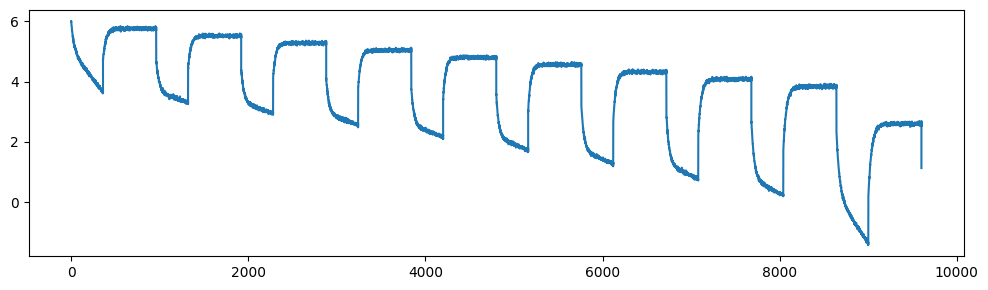

In [4]:
# Add noise to terminal voltage to create synthetic measurement
seed = 42
key = jax.random.PRNGKey(seed)

t_exp_data = sol.time
vt_exp_data = sol.outputs["vt"] + 0.03 * jax.random.normal(key, sol.outputs["vt"].shape)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t_exp_data, vt_exp_data, label=r"$v_t$: exp")
plt.tight_layout()
plt.show()

# # # Save synthetic experiment data
# jnp.save('synthetic_exp_data/t_exp_data', t_exp_data)
# jnp.save('synthetic_exp_data/vt_exp_data', vt_exp_data)

## Computing the $L_2$ error

Given the synthetic experimental data ($v_t$ measurements), our goal is to estimate the parameters of the battery so that the output of the model matches that of the experiment. We can use an discrepancy metric such as the $L_2$ error for this. Thus our optimization problem becomes:

$$ \hat{\theta} = \text{arg}\,\min\limits_{\theta}\ \int_0^{T} \left(v_t^{exp} - v_t(\theta) \right)^2 dt, $$

where $\theta$ represent the model parameters. In our case, we have 44 model parameters: 11 values per curve for the $v_0$, $R_s$, $R_1$, and $C_1$ curves.

To compute the loss function $\int_0^{T} \left(v_t^{exp} - v_t(\theta) \right)^2 dt$, we can use some additional primitive blocks to create a diagram that will compute the integral. We note that the integrand is a squared error. `Integrator` block is already available in the Collimator library, so all we need to do is to compute the squared error, which can be achieved through an `Adder` and `Power` blocks. Such a system, which takes two inputs $x$ and $y$ and computes $\int (x-y)^2$, can be created as follows:

In [5]:
from collimator.library import Adder, Power, Integrator, LookupTable1d, Clock


def make_l2_loss(name="l2_loss"):
    builder = collimator.DiagramBuilder()

    err = builder.add(
        Adder(2, operators="+-", name="err")
    )  # compute difference/error between the two input ports
    sq_err = builder.add(Power(2.0, name="sq_err"))  # square the above error
    sq_err_int = builder.add(Integrator(0.0, name="sq_err_int"))  # integrate

    builder.connect(err.output_ports[0], sq_err.input_ports[0])
    builder.connect(sq_err.output_ports[0], sq_err_int.input_ports[0])

    # Diagram level export inputs and outputs
    builder.export_input(err.input_ports[0])  # x
    builder.export_input(err.input_ports[1])  # y
    builder.export_output(sq_err_int.output_ports[0])  # \int (x-y)^2 dt

    return builder.build(name=name)

We also need to generate an interpolant block for the experimental data, which can be achieved through the `LookUpTable1d` block. With the experimental `t_exp_data` and `vt_exp_data` generated above as the parameters of such a block, the block output will be a linear interpolation of this data at any simulation time `t`.

The entire system can now be created as follows:

In [6]:
builder = collimator.DiagramBuilder()

discharge_current = builder.add(
    Pulse(100.0, 6 / 16.0, 16 * 60.0, name="discharge_current")
)

battery = builder.add(Battery(name="battery"))
l2_loss = builder.add(make_l2_loss(name="l2_loss"))

clock = builder.add(Clock(name="clock"))
vt_exp = builder.add(LookupTable1d(t_exp_data, vt_exp_data, "linear", name="vt_exp"))

builder.connect(discharge_current.output_ports[0], battery.input_ports[0])
builder.connect(clock.output_ports[0], vt_exp.input_ports[0])
builder.connect(battery.output_ports[1], l2_loss.input_ports[0])
builder.connect(vt_exp.output_ports[0], l2_loss.input_ports[1])

builder.export_output(l2_loss.output_ports[0])

diagram = builder.build()
context = diagram.create_context()

Initialized callback discharge_current:out_0 with prereqs [1]
Initialized callback battery:u_0 with prereqs []
Initialized callback battery:battery_ode with prereqs [1, 2, 8]
Initialized callback battery:y_0 with prereqs [8]
Initialized callback battery:y_1 with prereqs [8]
Initialized callback err:u_0 with prereqs []
Initialized callback err:u_1 with prereqs []
Initialized callback err:y_0 with prereqs [22, 23]
Initialized callback sq_err:u_0 with prereqs []
Initialized callback sq_err:y_0 with prereqs [25]
Initialized callback sq_err_int:in_0 with prereqs []
Initialized callback sq_err_int:sq_err_int_ode with prereqs [27]
Initialized callback sq_err_int:out_0 with prereqs [2]
Initialized callback l2_loss:err_u_0 with prereqs []
Initialized callback l2_loss:err_u_1 with prereqs []
Initialized callback l2_loss:sq_err_int_out_0 with prereqs [29]
Initialized callback clock:out_0 with prereqs [1]
Initialized callback vt_exp:u_0 with prereqs []
Initialized callback vt_exp:y_0 with prereqs 

We can now create a function to plot the results for any given set of parameters (11x4 values of the $v_0$, $R_s$, $R_1$, and $C_1$, curves)

In [18]:
def forward_plot(v0_points, Rs_points, R1_points, C1_points, context):
    new_params = {
        "v0_points": v0_points,
        "Rs_points": Rs_points,
        "R1_points": R1_points,
        "C1_points": C1_points,
    }

    subcontext = context[diagram["battery"].system_id].with_parameters(new_params)
    context = context.with_subcontext(diagram["battery"].system_id, subcontext)

    recorded_signals = {
        "vt": battery.output_ports[1],
        "vt_exp": vt_exp.output_ports[0],
        "soc": battery.output_ports[0],
        "discharge_current": discharge_current.output_ports[0],
        "l2_loss": l2_loss.output_ports[0],
    }

    options = SimulatorOptions(
        max_minor_step_size=1.0, max_major_steps=100, rtol=1e-06, atol=1e-08
    )

    sol = collimator.simulate(
        diagram,
        context,
        (0.0, 9600.0),
        options=options,
        recorded_signals=recorded_signals,
    )

    l2_loss_final = sol.outputs["l2_loss"][-1]
    print(f"{l2_loss_final=}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    ax1.plot(sol.time, sol.outputs["vt"], "-b", label="Terminal voltage: sim")
    ax1.plot(sol.time, sol.outputs["vt_exp"], "-r", label="Terminal voltage: exp")
    ax2.plot(sol.time, sol.outputs["l2_loss"], label=r"$\int e^2 dt$")
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    return fig

l2_loss_final=41872.90815306153


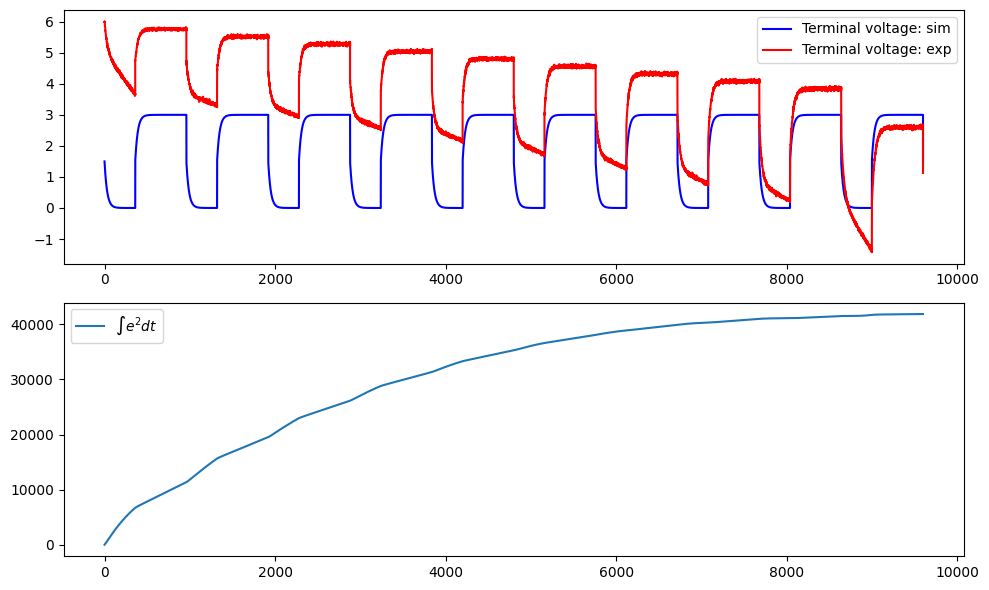

In [19]:
# run the simulation with arbitrarily chosen flat curves of v_0, Rs, R1, and C1 and plot the results
fig_forward = forward_plot(
    v0_points=3.0 * jnp.ones(11),
    Rs_points=15e-03 * jnp.ones(11),
    R1_points=15e-03 * jnp.ones(11),
    C1_points=2e03 * jnp.ones(11),
    context=context,
)
plt.show()

## Optimization setup

So now we have a way to obtain the L2 error. For parameter estimation, we need to minimise this error. Eliminating the overhead of recording the solution and only generating L2 error of interest we can write a more efficient function than one above. Before we do that, we need to ensure that during the optimization process, physically positive parameters of $v_0$, $R_s$, $R_1$, and $C_1$ do not become negative. One approach would be use constrained or at least box constrained optimizers. Alternatively, we can use unconstrained optimisation, but transform the parameters such that they never become negative. For the latter, we can use a logarithmic transformation of the following form for $v_0$, $R_s$, $R_1$, and $C_1$. Representing them generically as $\Psi$, we can apply a transformation of the following form:

$$ \Psi = \Psi_{\text{ref}}\, e^{\psi} $$.

Thus, for example, $v_0 = v_{0_{\text{ref}}} \, e^{\psi_{v_0}}$, and the optimisation variable is $\psi_{v_0}$ instead of $v_0$. Note that $\psi_{v_0}$ can be unconstrained while keeping the real parameter $v_0$ always positive. In the following code $\psi$ variables are labelled as `log_params`. 

In [20]:
# Define reference values
v0_ref = 3.0
Rs_ref = 10e-03
R1_ref = 15e-03
C1_ref = 2e03

options = SimulatorOptions(
    enable_autodiff=True,
    max_minor_step_size=1.0,
    max_major_steps=100,
    rtol=1e-06,
    atol=1e-08,
)


@jax.jit
def forward(log_params, context):
    # transform the log_params to real parametric space and update context
    params = jnp.exp(log_params)
    params_arr = params.reshape((4, 11))

    new_params = {
        "v0_points": v0_ref * params_arr[0, :],
        "Rs_points": Rs_ref * params_arr[1, :],
        "R1_points": R1_ref * params_arr[2, :],
        "C1_points": C1_ref * params_arr[3, :],
    }

    subcontext = context[diagram["battery"].system_id].with_parameters(new_params)
    context = context.with_subcontext(diagram["battery"].system_id, subcontext)

    sol = collimator.simulate(diagram, context, (0.0, 9600.0), options=options)

    l2_loss = sol.context[diagram["l2_loss"]["sq_err_int"].system_id].continuous_state

    # normalise the l2_loss and add regularisation (optional)
    cost = (1.0 / 9600) * l2_loss  # + (1.0/44)*1e-03*jnp.sum(log_params**2)
    return cost

In [21]:
# For some set of parameters (also initial guesses represented by `_0` suffix) run the simulation and print cost
v0_points_0 = 3.0 * jnp.ones(11)
Rs_points_0 = 15e-03 * jnp.ones(11)
R1_points_0 = 15e-03 * jnp.ones(11)
C1_points_0 = 2e03 * jnp.ones(11)

log_params_0 = jnp.hstack(
    [
        jnp.log(v0_points_0 / v0_ref),
        jnp.log(Rs_points_0 / Rs_ref),
        jnp.log(R1_points_0 / R1_ref),
        jnp.log(C1_points_0 / C1_ref),
    ]
)
cost = forward(log_params_0, context)
print(f"{cost=}")

cost=Array(4.36176127, dtype=float64, weak_type=True)


Note that Collimator models can be `jit` compiled as Collimator leverages the JAX framework. This is important for multiple fast runs and for automatically computing gradients, which can be used for many purposes including optimisation (as shown below).

### Optimization

Now that we have the `forward` function, we can leverage JAX's autodiff functionalities to compute the gradient of our `forward` function automatically.

In [22]:
grad_forward = jax.jit(jax.grad(forward))
grads_0 = grad_forward(log_params_0, context)
print(f"{grads_0.shape}")

(44,)


With the `jit` compiled `forward` and `grad_forward` functions created, we can leverage any optimisation framework (scipy, optax, jaxopt, etc.). We demonstrate optimisation with `scipy.optimize` first.

### Scipy

In [23]:
from scipy.optimize import minimize
from functools import partial

res = minimize(
    partial(forward, context=context),
    log_params_0,
    jac=partial(grad_forward, context=context),
    method="BFGS",
)
print(f"Optimization suceeded: {res.success}")
print(f"Optimized function value: {res.fun}")

Optimization suceeded: False
Optimized function value: 0.0005904284181043996


The optimizer's `success` status if `False`. It may have got stuck in a local minima, a common issue with gradient based optimizers. We can try with different guesses, rescaling the loss function, and/or reparameterizing the optimization variables. For now, let's proceed with the best solution found by the BFGS optimzer, and inspect the gradients at the optimal values

In [24]:
opt_log_params = jnp.array(res.x)
grad_forward(opt_log_params, context)

Array([-1.55489136e-06,  3.58014598e-05, -3.97460515e-05,  1.32297811e-05,
       -1.38293530e-05, -4.10720394e-06, -7.02997098e-06,  1.72810923e-05,
       -2.02723404e-05, -8.61888510e-07, -1.06755093e-05, -2.26160815e-05,
        6.42197905e-06,  2.72657905e-05, -2.81122350e-05,  3.27025920e-05,
       -4.71218460e-06, -2.19559786e-05, -3.33670309e-06,  2.49345121e-05,
       -4.30045826e-06,  1.61330234e-06,  1.12414280e-06,  1.20435626e-06,
       -1.60109200e-05,  4.56843887e-05, -4.34909228e-05, -1.59537917e-05,
        3.64798415e-05,  2.64939161e-05, -4.55410866e-05,  2.09774056e-05,
       -2.33986132e-05, -2.90281380e-06,  6.29827755e-06,  7.12326991e-06,
        7.27222252e-06, -4.71433221e-05, -9.64298188e-06,  3.10064997e-05,
        1.61310816e-05, -2.66565607e-05,  1.61604848e-05, -4.48037188e-05],      dtype=float64)

We see that they are small, implying a reasonable solution has been found. Next, we can plot the output $v_t$ with the optimal parameters and compare it with the experimental curve.

l2_loss_final=5.668112813802235


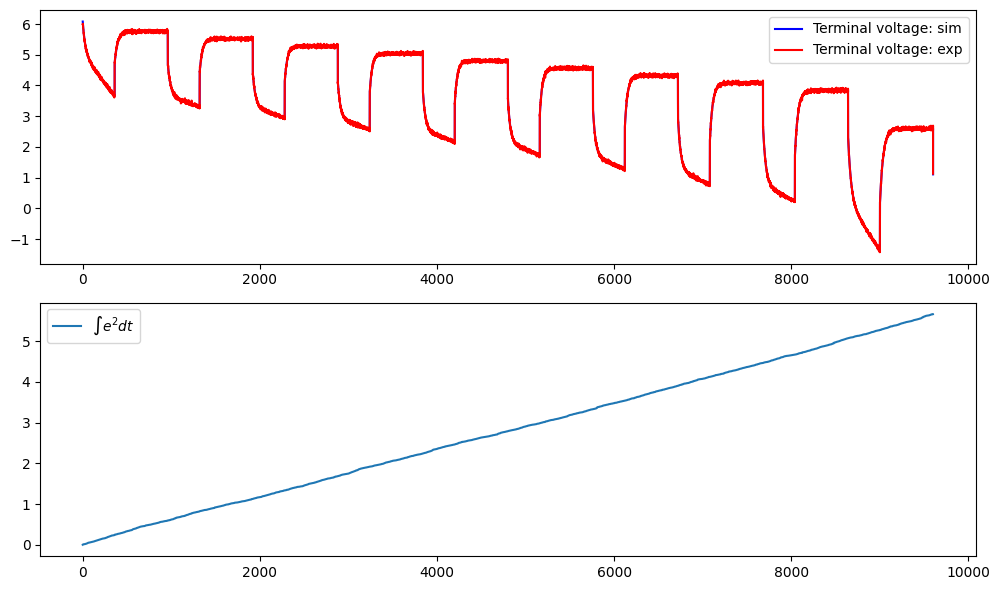

In [25]:
opt_log_params = jnp.array(res.x)

# Convert from \psi-space to real space
opt_params = jnp.exp(opt_log_params)
opt_params_arr = opt_params.reshape((4, 11))
opt_v0_points = v0_ref * opt_params_arr[0, :]
opt_Rs_points = Rs_ref * opt_params_arr[1, :]
opt_R1_points = R1_ref * opt_params_arr[2, :]
opt_C1_points = C1_ref * opt_params_arr[3, :]

# Plot the results
fig_opt = forward_plot(
    v0_points=opt_v0_points,
    Rs_points=opt_Rs_points,
    R1_points=opt_R1_points,
    C1_points=opt_C1_points,
    context=context,
)
plt.show()

We see that the simulation output with optimal parameter curves closely follows the experimental data. Note that with the addition of noise, the optimal parameters are not necessarily unique. In the absence of any further data, the only information we have to estimate the parameters is the experimental $v_t$ curve. We can compare the optimal solution found against the true known parameters, a luxury only available for synthetic data.

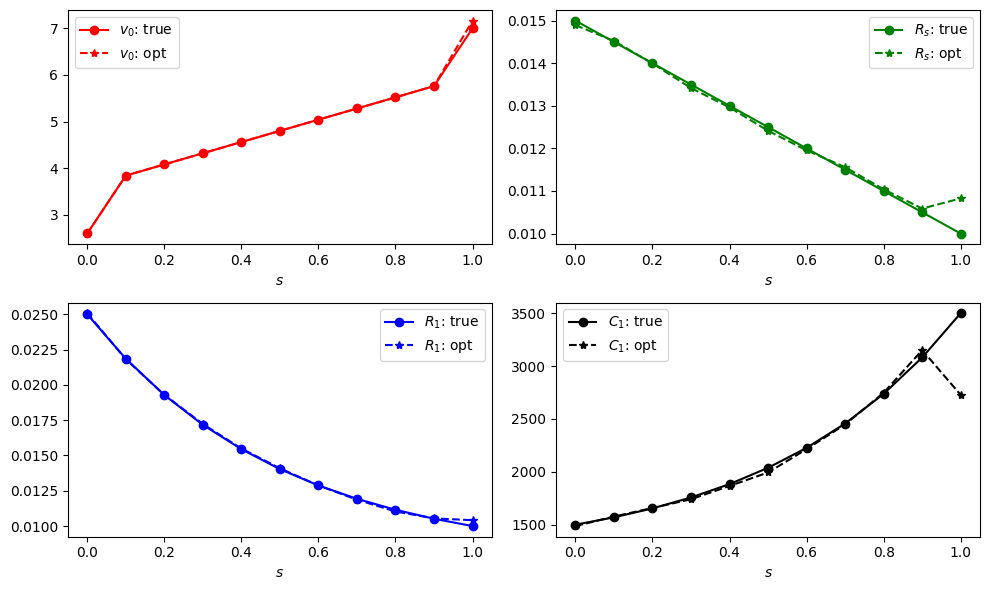

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(soc_points_true, v0_points_true, "-ro", label=f"$v_0$: true")
axs[0, 1].plot(soc_points_true, Rs_points_true, "-go", label=f"$R_s$: true")
axs[1, 0].plot(soc_points_true, R1_points_true, "-bo", label=f"$R_1$: true")
axs[1, 1].plot(soc_points_true, C1_points_true, "-ko", label=f"$C_1$: true")

axs[0, 0].plot(soc_points_true, opt_v0_points, "--r*", label=f"$v_0$: opt")
axs[0, 1].plot(soc_points_true, opt_Rs_points, "--g*", label=f"$R_s$: opt")
axs[1, 0].plot(soc_points_true, opt_R1_points, "--b*", label=f"$R_1$: opt")
axs[1, 1].plot(soc_points_true, opt_C1_points, "--k*", label=f"$C_1$: opt")

for ax in axs.flatten():
    ax.set_xlabel(r"$s$")
    ax.legend(loc="best")
plt.tight_layout()
plt.show()

The optimizer does a decent job of estimating the curves. As mentioned earlier potential avenues for improvement are rescaling of the parmaeters and loss function, and/or trying different initial guesses. The optimization results are not bad through, particularly in light that parameters are not unique and many combinations of the parameters, including the one found by the optimiser, are able to reproduce the experimental data. With `callback` functions (see scipy documentation), one can visualise, how the parameters evolved during the optimization process. See example below for the same problem, but different initial conditions.

<img src="../media/battery_optimization.gif" alt="BFGS parameter evolution" width=900px/>

One can also try changing initial conditions and/or trying different solvers. Next, we demonstrate how we can use `optax` for optimization of our model.

### Optax
With optax, we use the `Adam` optimizer and use our `jit` compiled `grad_forward` function to compute the gradients.

In [27]:
import optax

# Optax optimizer
optimizer = optax.adam(learning_rate=0.01)

# Initialize optimizer state
log_params = log_params_0
opt_state = optimizer.init(log_params)

# Gradient descent loop
num_epochs = 1000
for epoch in range(num_epochs):
    gradients = grad_forward(log_params, context)
    updates, opt_state = optimizer.update(gradients, opt_state)
    log_params = optax.apply_updates(log_params, updates)

    # Print the function value at the current parameters
    if (epoch + 1) % 50 == 0:
        current_function_value = forward(log_params, context)
        print(
            f"Epoch [{epoch+1}/{num_epochs}]: forward(log_params) = {current_function_value}"
        )

Epoch [50/1000]: forward(log_params) = 0.2705149630201369
Epoch [100/1000]: forward(log_params) = 0.013166587006923556
Epoch [150/1000]: forward(log_params) = 0.0047556279869248735
Epoch [200/1000]: forward(log_params) = 0.0024054038207664565
Epoch [250/1000]: forward(log_params) = 0.00146151055343063
Epoch [300/1000]: forward(log_params) = 0.0010475787233728876
Epoch [350/1000]: forward(log_params) = 0.000849419857044777
Epoch [400/1000]: forward(log_params) = 0.0007485938541607815
Epoch [450/1000]: forward(log_params) = 0.0006923545683565235
Epoch [500/1000]: forward(log_params) = 0.0006597271690309499
Epoch [550/1000]: forward(log_params) = 0.0006399327014223154
Epoch [600/1000]: forward(log_params) = 0.0006272214222676555
Epoch [650/1000]: forward(log_params) = 0.0006187171205653079
Epoch [700/1000]: forward(log_params) = 0.0006129704618094624
Epoch [750/1000]: forward(log_params) = 0.0006088569872850691
Epoch [800/1000]: forward(log_params) = 0.0006054723238707175
Epoch [850/1000]

Similarly to the `scipy` case, we can plot the results of the optimal solution found.

l2_loss_final=5.740969383965497


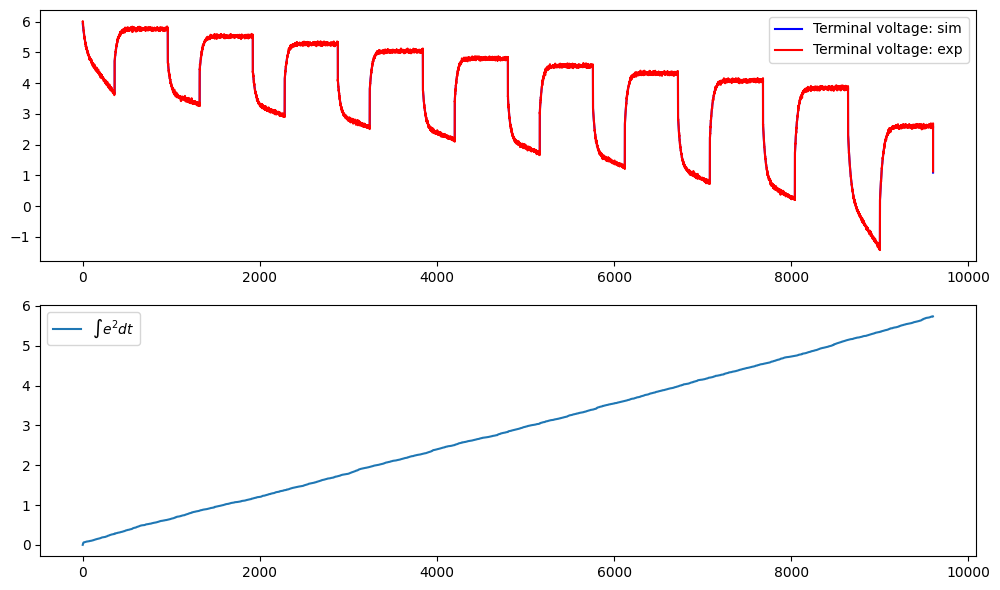

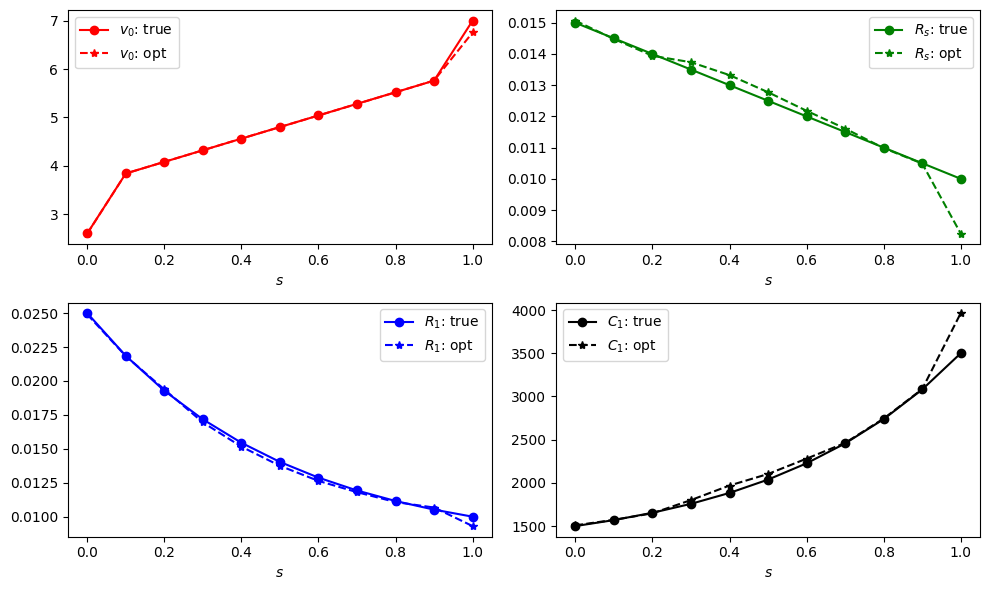

In [28]:
opt_log_params = log_params

# Convert from \psi-space to real space
opt_params = jnp.exp(opt_log_params)
opt_params_arr = opt_params.reshape((4, 11))
opt_v0_points = v0_ref * opt_params_arr[0, :]
opt_Rs_points = Rs_ref * opt_params_arr[1, :]
opt_R1_points = R1_ref * opt_params_arr[2, :]
opt_C1_points = C1_ref * opt_params_arr[3, :]

# Plot the results
fig_opt = forward_plot(
    v0_points=opt_v0_points,
    Rs_points=opt_Rs_points,
    R1_points=opt_R1_points,
    C1_points=opt_C1_points,
    context=context,
)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(soc_points_true, v0_points_true, "-ro", label=f"$v_0$: true")
axs[0, 1].plot(soc_points_true, Rs_points_true, "-go", label=f"$R_s$: true")
axs[1, 0].plot(soc_points_true, R1_points_true, "-bo", label=f"$R_1$: true")
axs[1, 1].plot(soc_points_true, C1_points_true, "-ko", label=f"$C_1$: true")

axs[0, 0].plot(soc_points_true, opt_v0_points, "--r*", label=f"$v_0$: opt")
axs[0, 1].plot(soc_points_true, opt_Rs_points, "--g*", label=f"$R_s$: opt")
axs[1, 0].plot(soc_points_true, opt_R1_points, "--b*", label=f"$R_1$: opt")
axs[1, 1].plot(soc_points_true, opt_C1_points, "--k*", label=f"$C_1$: opt")

for ax in axs.flatten():
    ax.set_xlabel(r"$s$")
    ax.legend(loc="best")
plt.tight_layout()
plt.show()